In [1]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
sns.set_style('white')
sns.set_context('paper')

In [3]:
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

In [4]:
seed = 0

torch.manual_seed(seed)
rng = np.random.default_rng(seed)

In [5]:
accs = np.load(r'./data/mnist_sparsity_performance_lr0025_m9_FINAL.npy', allow_pickle=True)
accs.shape

(5, 5, 20)

In [6]:
alphas = [1.0, 2.0, 3.0, 4.0, 5.0]
model_types = []
for alpha in alphas:
    if alpha > 1.0:
        model_types.append('Powerprop. ($\\alpha={}$)'.format(alpha))
    else:
        model_types.append('Baseline')

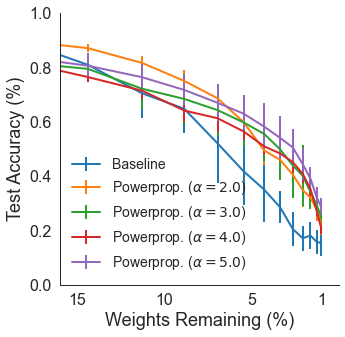

In [7]:
means = accs.mean(axis=0)
stds = accs.std(axis=0)

sparsity_levels = 100 * np.geomspace(0.01, 1.0, 20)

f, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, label in enumerate(model_types):
    ax.errorbar(sparsity_levels, means[i], yerr=stds[i], label=label, lw=2)

ax.set_xlim([16.0, 0.0])
ax.set_ylim([0.0, 1.0])
ax.legend(frameon=False)
ax.grid(False)
ax.set_xticks([15, 10, 5, 1])
ax.set_xlabel('Weights Remaining (%)')
ax.set_ylabel('Test Accuracy (%)')

sns.despine()

In [50]:
# initial_weights = np.load(r'./data/mnist_initial_weights_lr0025_m9_FINAL.npy', allow_pickle=True)
# final_weights = np.load(r'./data/mnist_final_weights_lr0025_m9_FINAL.npy', allow_pickle=True)

initial_weights = np.load(r'./data/mnist_initial_weights_lr01_m0_FINAL.npy', allow_pickle=True)
final_weights = np.load(r'./data/mnist_final_weights_lr01_m0_FINAL.npy', allow_pickle=True)
initial_weights.shape, final_weights.shape

((5, 5, 3), (5, 5, 3))

In [61]:
# weight distribution

def prune_weights(initial, final, p=0.1):
    cond = np.abs(final.flatten())
    n = int(p * cond.shape[0])
    top_k = np.argsort(cond)[::-1][:n]
    # how_many = int(p * cond.shape[0])
    # top_k = torch.topk(condition, k=how_many).indices
    
    # remaining weights
    init_rem = initial.flatten()[top_k]    
    final_rem = final.flatten()[top_k]
    remaining = np.column_stack((init_rem, final_rem))
    
    # pruned weights
    mask = np.ones(cond.shape, bool)
    mask[top_k] = False
    init_pruned = initial.flatten()[mask]
    final_pruned = final.flatten()[mask]
    pruned = np.column_stack((init_pruned, final_pruned))
    
    return remaining, pruned

def sample_weights(w):
    # sample 10k elements
    weights = np.vstack(w)
    idx = rng.choice(np.arange(weights.shape[0]), size=10000)
    return weights[idx, :], idx

def pick_same_weights(w, idx):
    weights = np.vstack(w)
    return weights[idx, :]

def plot_weights(remaining, pruned):
    n = pruned.shape[0]
    data = {
        'Initial weight': np.hstack((pruned[:, 0], remaining[:, 0])),
        'Final weight': np.hstack((pruned[:, 1], remaining[:, 1])),
        'type': ['Pruned weights'] * n + ['Remaining weights'] * n
    }
    
    g = sns.jointplot(data=data, x='Initial weight', y='Final weight', hue='type')
    g.ax_joint.legend(frameon=False).set_title(None)
    g.ax_joint.set_yscale('symlog')
    g.ax_joint.set_yticks([-1e1, -1e0, 0.0, 1e0, 1e1])
    g.ax_joint.set_ylim([-2e1, 2e1])
    sns.rugplot(data=data, y='Final weight', hue='type', height=0.5, ax=g.ax_marg_y, legend=False)

(10000, 2) (10000,)
(10000, 2)


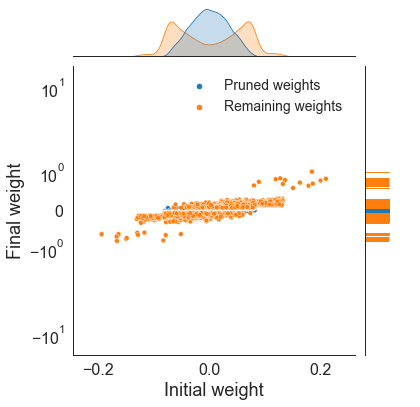

In [65]:
remains, prunes = [], []
for fw, iw in zip(final_weights[0, 0], initial_weights[0, 0]):
    rem, pru = prune_weights(iw, fw)
    remains.append(rem)
    prunes.append(pru)
    
remaining, rem_idx = sample_weights(remains)
# pruned = sample_weights(prunes)
print(remaining.shape, rem_idx.shape)
pruned = pick_same_weights(prunes, rem_idx)
print(pruned.shape)
plot_weights(remaining, pruned)

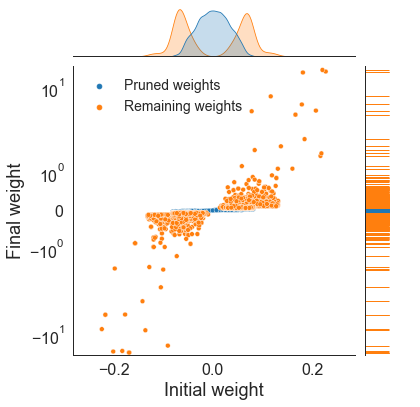

In [64]:
remains, prunes = [], []
for fw, iw in zip(final_weights[0, 3], initial_weights[0, 3]):
    rem, pru = prune_weights(iw, fw)
    remains.append(rem)
    prunes.append(pru)
    
remaining, rem_idx = sample_weights(remains)
# pruned = sample_weights(prunes)
pruned = pick_same_weights(prunes, rem_idx)
plot_weights(remaining, pruned)

In [37]:
x = np.ones(10)
x.nonzero()[0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [42]:
(x == 1).nonzero()[0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [55]:
# mask overlap

def create_mask_old(arr, prob):
    cond = np.abs(arr.flatten())
    return np.argsort(cond)[:int(prob * cond.shape[0])]

def create_mask(arr, prob):
    cond = np.abs(arr.flatten())
    top_idx = np.argsort(cond)[-int(prob * cond.shape[0]):]
    mask = np.zeros(cond.shape)
    mask[top_idx] = 1
    return mask.reshape(arr.shape)

def mask_overlap_old(initial, final, prob):
    init_mask = create_mask_old(initial, prob)  
    final_mask = create_mask_old(final, prob)
    overlap = np.intersect1d(init_mask, final_mask, assume_unique=True).shape[0]
    return overlap, init_mask.shape[0]

def mask_overlap(initial, final, prob):
    init_mask = create_mask(initial, prob)  
    final_mask = create_mask(final, prob)
    overlap = np.sum(init_mask == final_mask)
    return overlap, initial.size # init_mask.size

results = []
for r in range(5):
    rep_res = []
    for alpha in range(4):
        alpha_res = []
        for p in (0.5, 0.85, 0.95):
            total_overlap, total = 0, 0
            for fw, iw in zip(final_weights[r, alpha], initial_weights[r, alpha]):
                overlap, number = mask_overlap(iw, fw, p)
                total_overlap += overlap
                total += number

            alpha_res.append(total_overlap / total)
            print(r, alpha, p, total_overlap / total)
        rep_res.append(alpha_res)
    results.append(rep_res)

0 0 0.5 0.7796919609316304
0 0 0.85 0.8523666416228399
0 0 0.95 0.9346055597295266
0 1 0.5 0.910488354620586
0 1 0.85 0.9630127723516153
0 1 0.95 0.9869045830202855
0 2 0.5 0.9297821187077385
0 2 0.85 0.9821111945905334
0 2 0.95 0.9958076634109692
0 3 0.5 0.9256498873027799
0 3 0.85 0.984748309541698
0 3 0.95 0.9973854244928625
1 0 0.5 0.7821337340345604
1 0 0.85 0.855244177310293
1 0 0.95 0.9358302028549963
1 1 0.5 0.9110142749812171
1 1 0.85 0.9628099173553719
1 1 0.95 0.9868670172802404
1 2 0.5 0.9305709992486852
1 2 0.85 0.9831329827197596
1 2 0.95 0.9958978211870774
1 3 0.5 0.9275807663410969
1 3 0.85 0.9853643876784373
1 3 0.95 0.997618332081142
2 0 0.5 0.7797595792637115
2 0 0.85 0.853824192336589
2 0 0.95 0.935251690458302
2 1 0.5 0.9102704733283246
2 1 0.85 0.9616303531179564
2 1 0.95 0.9859053343350864
2 2 0.5 0.9267317806160781
2 2 0.85 0.9812546957175057
2 2 0.95 0.9955672426746807
2 3 0.5 0.9266942148760331
2 3 0.85 0.9854169797145004
2 3 0.95 0.9970247933884298
3 0 0.5 0.

In [56]:
res = np.array(results)
means = res.mean(axis=0)
stds = res.std(axis=0)
means.shape

(4, 3)

In [57]:
res[0, 0]

array([0.77969196, 0.85236664, 0.93460556])

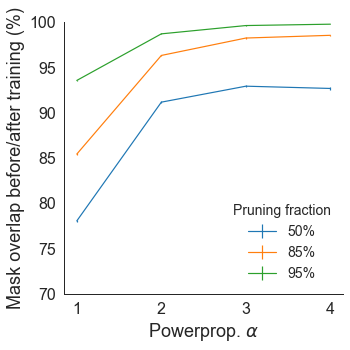

In [58]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

labels = ['50%', '85%', '95%']
for i in range(3):
    ax.errorbar(x=[1, 2, 3, 4], y=100 * means[:, i], yerr=100 * stds[:, i], label=labels[i])
    

ax.set_xlabel(r'Powerprop. $\alpha$')
ax.set_ylabel('Mask overlap before/after training (%)')
ax.set_ylim([70, 100])
ax.set_xticks([1.0, 2.0, 3.0, 4.0])
ax.legend(title='Pruning fraction', frameon=False)
sns.despine()
plt.show()

In [59]:
# 10k smallest weights

res = []
alphas = np.arange(3)
for alpha in alphas:
    fws = [fw.flatten() for fw in final_weights[0, alpha]]
    fws = np.concatenate(fws)
    smallest = np.argsort(np.abs(fws))[:10000]
    res.append(fws[smallest])

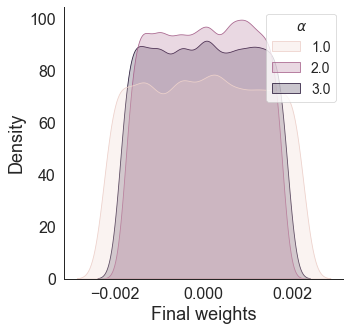

In [60]:
n = res[0].shape
data = {
        'weights': np.hstack(res),
        r'$\alpha$': np.repeat(1.0 + alphas, n)
}
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.kdeplot(data=data, x='weights', hue=r'$\alpha$', ax=ax, fill=True)
ax.set_xlabel('Final weights')
sns.despine()
plt.show()